In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# define fixed parameters

#conductances
C_m = 1.0e-9

# volatages
V_leak = -40.0e-3 # 40 mV
V_Ca = 100.0e-3 # 100mV
V_k = -80.0e-3 # -80mV
V_h = -20.0e-3 # -20mV
V_syn = -75.0e-3 # -75mV

v_1 = 0.0 # 0mV
v_2 = 20.0e-3 # 20mV
v_3 = 0.0 # 0mV
v_4 = 15.0e-3 # 15mV
v_5 = 78.3e-3 # 78.3mV
v_6 = 10.5e-3 # 10.5mV
v_7 = -42.2e-3 # -42.2mV
v_8 = 87.3e-3 # 87.3mV
v_9 = 5.0e-3  # 5.0mV

v_th = -25.0e-3 # -25mV

# neuron specific conductances
g_Ca_f = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_Ca_h = 1.7e-2 * (1e-6) # 1.7e-2 \mu S
g_Ca_s = 8.5e-3 * (1e-6) # 8.5e-3 \mu S

g_k_f  = 3.9e-2 * (1e-6) # 3.9e-2 \mu S
g_k_h  = 1.9e-2 * (1e-6) # 1.9e-2 \mu S
g_k_s  = 1.5e-2 * (1e-6) # 1.5e-2 \mu S

g_h_f  = 2.5e-2 * (1e-6) # 2.5e-2 \mu S
g_h_h  = 8.0e-3 * (1e-6) # 8.0e-3 \mu S
g_h_s  = 1.0e-2 * (1e-6) # 1.0e-2 \mu S

g_Ca = np.array([g_Ca_f, g_Ca_f, g_Ca_h, g_Ca_s, g_Ca_s])
g_k = np.array([g_k_f, g_k_f, g_k_h, g_k_s, g_k_s])
g_h = np.array([g_h_f, g_h_f, g_h_h, g_h_s, g_h_s])

g_leak = 1.0e-4 * (1e-6) # 1e-4 \mu S

phi_N = 2 # 0.002 ms^-1


    

## state representation

The state variable $x$ is comprised of three, five-dimensional state variables ($V_m$, $N$, and $H$) for each neuron.

$$x = \begin{bmatrix} V_m \\ N \\ H \end{bmatrix}$$
$$V_m = \begin{bmatrix} V_{m,f_1} \\ V_{m,f_2} \\ V_{m,h_n} \\ V_{m,s_1} \\ V_{m,s_2} \end{bmatrix} \hspace{1cm}
N = \begin{bmatrix} N_{f_1} \\ N_{f_2} \\ N_{h_n} \\ N_{s_1} \\ N_{s_2} \end{bmatrix} \hspace{1cm}
H = \begin{bmatrix} H_{f_1} \\ H_{f_2} \\ H_{h_n} \\ H_{s_1} \\ H_{s_2} \end{bmatrix} 
$$

In [61]:

def f(x, g_el, g_synA, g_synB):
    # x contains
    V_m = x[:5]
    N = x[5:10]
    H = x[10:]
    
    M_inf = 0.5*(1.0 + np.tanh((V_m - v_1)/ v_2))
    N_inf = 0.5*(1.0 + np.tanh((V_m - v_3)/v_4))
    H_inf = 1.0 / (1.0 + np.exp((V_m + v_5)/v_6))
                   
    S_inf = 1.0 / (1.0 + np.exp((v_th - V_m) / v_9))
    
    I_leak = g_leak*(V_m - V_leak)
    I_Ca = g_Ca*M_inf*(V_m - V_Ca)
    I_k = g_k*N*(V_m - V_k)
    I_h = g_h*H*(V_m - V_h)
                   
    I_elec = np.array([0.0, 
                       g_el*(V_m[1]-V_m[2]),
                       g_el*(V_m[2]-V_m[1] + V_m[2]-V_m[4]),
                       0.0,
                       g_el*(V_m[4]-V_m[2])])
                   
    I_syn = np.array([g_synB*S_inf[1]*(V_m[0] - V_syn),
                        g_synB*S_inf[0]*(V_m[1] - V_syn),
                        g_synA*S_inf[0]*(V_m[2] - V_syn) + g_synA*S_inf[3]*(V_m[2] - V_syn),
                        g_synB*S_inf[4]*(V_m[3] - V_syn),
                        g_synB*S_inf[3]*(V_m[4] - V_syn)])

    I_total = I_leak + I_Ca + I_k + I_h + I_elec + I_syn    
    
    lambda_N = (phi_N)*np.cosh((V_m - v_3)/(2*v_4))
    tau_h = (272.0 - (-1499.0 / (1.0 + np.exp((-V_m + v_7) / v_8)))) / 1000.0
    
    dVmdt = (1.0 / C_m)*(-I_total)
    dNdt = lambda_N*(N_inf - N)
    dHdt = (H_inf - H) / tau_h
    
    dxdt = np.concatenate((dVmdt, dNdt, dHdt), axis=0)
    return dxdt
                   

In [62]:
# parameters for the DSN
g_el = np.arange(0.1, 8.0, 0.25) * (1e-9) # .25 nS  (.25-7.5 nS) range
g_synA = np.arange(0.1, 8.0, 0.25) * (1e-9) # .25 nS  (.25-10 nS) range
#g_el = np.array([1.1])*1e-9
#g_synA = np.array([3.2])*1e-9
g_synB = 5.0 * (1e-9) # .25 nS  (.25-10 nS) range

num_g_el = g_el.shape[0]
num_g_synA = g_synA.shape[0]

In [92]:
import time
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

V_m0 = -65.0e-3*np.ones((5,))
N_0 = 0.25*np.ones((5,))
H_0 = 0.1*np.ones((5,))
#x0 = np.concatenate((V_m0, N_0, H_0), axis=0)

# red tongue init
"""x0 = np.array([-0.05396623, -0.02110229, -0.04078849, -0.0585101,  -0.04425548,
               0.0160548, 0.00819903, 0.00140394, 0.02428747, 0.00122073,
               0.10245851,  0.08343522, 0.14188061,  0.0758458,   0.11325111])"""

x0 = np.array([-0.03140991, -0.03494656, -0.00886472, -0.06851396,  0.00570002,
               0.00375753, 0.11949047, 0.57696811, 0.02869717, 0.5140996,
               0.07868617, 0.04647705, 0.0502322, 0.09902459, 0.0524811])

x = x0
T = 210
fft_start = 10
dt = 0.025

w = 20

N = T - fft_start + 1 - (w-1) 

Fs = 1.0 / dt

phi_ts = []
min_freq = 0.0
max_freq = 1.0
num_freqs = 101
freqs = np.linspace(min_freq, max_freq, num_freqs)

ns = np.arange(0,N)
for i in range(num_freqs):
    freq_i = freqs[i]
    k = N*freq_i / Fs
    phi_t = np.cos(2*np.pi*k*ns/N) - 1j * np.sin(2*np.pi*k*ns/N)
    phi_ts.append(phi_t)
    
Phi = np.array(phi_ts)

max_freqs = np.zeros((num_g_el, num_g_synA))
for i in range(num_g_el):
    for j in range(num_g_synA):
        print(i,j,g_el[i], g_synA[j])
        start_time = time.time()
        x = x0
        xs = [x0]
        for t in range(T):
            dxdt = f(x, g_el[i], g_synA[j], g_synB)
            x = dxdt*dt + x
            xs.append(x)
        X = np.array(xs)
        X_end = X[fft_start:,2]
        #plt.figure()
        #plt.plot(X_end)
        #plt.show()
        X_rect = np.maximum(X_end, 0.00)
        X_rect_LPF = moving_average(X_rect, w)
        X_rect_LPF = X_rect_LPF - np.mean(X_rect_LPF)
        Xk = np.dot(Phi, X_rect_LPF)
        #plt.figure()
        #plt.plot(np.abs(Xk))
        #plt.title('X_k')
        plt.show()
        ind = np.argmax(np.abs(Xk))
        
        max_freqs[i,j] = freqs[ind]
        print('took', time.time() - start_time)

0 0 1.0000000000000002e-10 1.0000000000000002e-10
took 0.017729997634887695
0 1 1.0000000000000002e-10 3.5e-10
took 0.016028881072998047
0 2 1.0000000000000002e-10 6e-10
took 0.015928983688354492
0 3 1.0000000000000002e-10 8.5e-10
took 0.01552581787109375
0 4 1.0000000000000002e-10 1.1e-09
took 0.013840913772583008
0 5 1.0000000000000002e-10 1.3499999999999999e-09
took 0.013226985931396484
0 6 1.0000000000000002e-10 1.6e-09
took 0.013551950454711914
0 7 1.0000000000000002e-10 1.85e-09
took 0.012863397598266602
0 8 1.0000000000000002e-10 2.0999999999999998e-09
took 0.013776063919067383
0 9 1.0000000000000002e-10 2.35e-09
took 0.013562917709350586
0 10 1.0000000000000002e-10 2.5999999999999997e-09
took 0.012782096862792969
0 11 1.0000000000000002e-10 2.85e-09
took 0.013393878936767578
0 12 1.0000000000000002e-10 3.0999999999999996e-09
took 0.013177156448364258
0 13 1.0000000000000002e-10 3.35e-09
took 0.013916015625
0 14 1.0000000000000002e-10 3.6e-09
took 0.013935089111328125
0 15 1.000

took 0.014641284942626953
4 16 1.1e-09 4.0999999999999995e-09
took 0.013360977172851562
4 17 1.1e-09 4.349999999999999e-09
took 0.013404369354248047
4 18 1.1e-09 4.599999999999999e-09
took 0.015137910842895508
4 19 1.1e-09 4.849999999999999e-09
took 0.013391733169555664
4 20 1.1e-09 5.099999999999999e-09
took 0.013939857482910156
4 21 1.1e-09 5.349999999999999e-09
took 0.013020038604736328
4 22 1.1e-09 5.599999999999999e-09
took 0.013236045837402344
4 23 1.1e-09 5.8499999999999994e-09
took 0.013242244720458984
4 24 1.1e-09 6.099999999999999e-09
took 0.013058185577392578
4 25 1.1e-09 6.349999999999999e-09
took 0.013108015060424805
4 26 1.1e-09 6.5999999999999995e-09
took 0.013482093811035156
4 27 1.1e-09 6.849999999999999e-09
took 0.013099908828735352
4 28 1.1e-09 7.099999999999999e-09
took 0.012613058090209961
4 29 1.1e-09 7.349999999999999e-09
took 0.012781143188476562
4 30 1.1e-09 7.599999999999999e-09
took 0.012922048568725586
4 31 1.1e-09 7.849999999999999e-09
took 0.01358985900878

took 0.014068126678466797
8 26 2.0999999999999998e-09 6.5999999999999995e-09
took 0.014238357543945312
8 27 2.0999999999999998e-09 6.849999999999999e-09
took 0.013688087463378906
8 28 2.0999999999999998e-09 7.099999999999999e-09
took 0.014611959457397461
8 29 2.0999999999999998e-09 7.349999999999999e-09
took 0.018411874771118164
8 30 2.0999999999999998e-09 7.599999999999999e-09
took 0.021571874618530273
8 31 2.0999999999999998e-09 7.849999999999999e-09
took 0.017674922943115234
9 0 2.35e-09 1.0000000000000002e-10
took 0.016088008880615234
9 1 2.35e-09 3.5e-10
took 0.014401912689208984
9 2 2.35e-09 6e-10
took 0.013628005981445312
9 3 2.35e-09 8.5e-10
took 0.013061285018920898
9 4 2.35e-09 1.1e-09
took 0.012739896774291992
9 5 2.35e-09 1.3499999999999999e-09
took 0.013149023056030273
9 6 2.35e-09 1.6e-09
took 0.013730049133300781
9 7 2.35e-09 1.85e-09
took 0.012872934341430664
9 8 2.35e-09 2.0999999999999998e-09
took 0.01298213005065918
9 9 2.35e-09 2.35e-09
took 0.012417078018188477
9 1

took 0.01343679428100586
13 1 3.35e-09 3.5e-10
took 0.013318061828613281
13 2 3.35e-09 6e-10
took 0.01328277587890625
13 3 3.35e-09 8.5e-10
took 0.014432907104492188
13 4 3.35e-09 1.1e-09
took 0.014323949813842773
13 5 3.35e-09 1.3499999999999999e-09
took 0.01358175277709961
13 6 3.35e-09 1.6e-09
took 0.013665199279785156
13 7 3.35e-09 1.85e-09
took 0.012885093688964844
13 8 3.35e-09 2.0999999999999998e-09
took 0.013288736343383789
13 9 3.35e-09 2.35e-09
took 0.01304006576538086
13 10 3.35e-09 2.5999999999999997e-09
took 0.013279199600219727
13 11 3.35e-09 2.85e-09
took 0.013106822967529297
13 12 3.35e-09 3.0999999999999996e-09
took 0.012981891632080078
13 13 3.35e-09 3.35e-09
took 0.01419520378112793
13 14 3.35e-09 3.6e-09
took 0.012662887573242188
13 15 3.35e-09 3.85e-09
took 0.013327836990356445
13 16 3.35e-09 4.0999999999999995e-09
took 0.012325763702392578
13 17 3.35e-09 4.349999999999999e-09
took 0.013705968856811523
13 18 3.35e-09 4.599999999999999e-09
took 0.012494087219238281


took 0.013666152954101562
17 20 4.349999999999999e-09 5.099999999999999e-09
took 0.013791084289550781
17 21 4.349999999999999e-09 5.349999999999999e-09
took 0.014660120010375977
17 22 4.349999999999999e-09 5.599999999999999e-09
took 0.013930082321166992
17 23 4.349999999999999e-09 5.8499999999999994e-09
took 0.012853145599365234
17 24 4.349999999999999e-09 6.099999999999999e-09
took 0.012974977493286133
17 25 4.349999999999999e-09 6.349999999999999e-09
took 0.012785911560058594
17 26 4.349999999999999e-09 6.5999999999999995e-09
took 0.01350092887878418
17 27 4.349999999999999e-09 6.849999999999999e-09
took 0.013221025466918945
17 28 4.349999999999999e-09 7.099999999999999e-09
took 0.013278007507324219
17 29 4.349999999999999e-09 7.349999999999999e-09
took 0.013528823852539062
17 30 4.349999999999999e-09 7.599999999999999e-09
took 0.01326894760131836
17 31 4.349999999999999e-09 7.849999999999999e-09
took 0.013539791107177734
18 0 4.599999999999999e-09 1.0000000000000002e-10
took 0.01464

took 0.013607978820800781
21 10 5.349999999999999e-09 2.5999999999999997e-09
took 0.013827800750732422
21 11 5.349999999999999e-09 2.85e-09
took 0.013864994049072266
21 12 5.349999999999999e-09 3.0999999999999996e-09
took 0.014878988265991211
21 13 5.349999999999999e-09 3.35e-09
took 0.014164924621582031
21 14 5.349999999999999e-09 3.6e-09
took 0.013334035873413086
21 15 5.349999999999999e-09 3.85e-09
took 0.013852834701538086
21 16 5.349999999999999e-09 4.0999999999999995e-09
took 0.013440132141113281
21 17 5.349999999999999e-09 4.349999999999999e-09
took 0.014552831649780273
21 18 5.349999999999999e-09 4.599999999999999e-09
took 0.013056039810180664
21 19 5.349999999999999e-09 4.849999999999999e-09
took 0.013329029083251953
21 20 5.349999999999999e-09 5.099999999999999e-09
took 0.01324605941772461
21 21 5.349999999999999e-09 5.349999999999999e-09
took 0.013366937637329102
21 22 5.349999999999999e-09 5.599999999999999e-09
took 0.013190984725952148
21 23 5.349999999999999e-09 5.8499999

took 0.013011932373046875
25 17 6.349999999999999e-09 4.349999999999999e-09
took 0.014735698699951172
25 18 6.349999999999999e-09 4.599999999999999e-09
took 0.013441085815429688
25 19 6.349999999999999e-09 4.849999999999999e-09
took 0.014813899993896484
25 20 6.349999999999999e-09 5.099999999999999e-09
took 0.012450218200683594
25 21 6.349999999999999e-09 5.349999999999999e-09
took 0.013556957244873047
25 22 6.349999999999999e-09 5.599999999999999e-09
took 0.012965202331542969
25 23 6.349999999999999e-09 5.8499999999999994e-09
took 0.013615846633911133
25 24 6.349999999999999e-09 6.099999999999999e-09
took 0.013165950775146484
25 25 6.349999999999999e-09 6.349999999999999e-09
took 0.012772321701049805
25 26 6.349999999999999e-09 6.5999999999999995e-09
took 0.01363992691040039
25 27 6.349999999999999e-09 6.849999999999999e-09
took 0.013426065444946289
25 28 6.349999999999999e-09 7.099999999999999e-09
took 0.01300191879272461
25 29 6.349999999999999e-09 7.349999999999999e-09
took 0.01337

took 0.012810945510864258
29 15 7.349999999999999e-09 3.85e-09
took 0.012749910354614258
29 16 7.349999999999999e-09 4.0999999999999995e-09
took 0.013331174850463867
29 17 7.349999999999999e-09 4.349999999999999e-09
took 0.013300895690917969
29 18 7.349999999999999e-09 4.599999999999999e-09
took 0.013533830642700195
29 19 7.349999999999999e-09 4.849999999999999e-09
took 0.015324831008911133
29 20 7.349999999999999e-09 5.099999999999999e-09
took 0.012717962265014648
29 21 7.349999999999999e-09 5.349999999999999e-09
took 0.01279306411743164
29 22 7.349999999999999e-09 5.599999999999999e-09
took 0.013285160064697266
29 23 7.349999999999999e-09 5.8499999999999994e-09
took 0.013798713684082031
29 24 7.349999999999999e-09 6.099999999999999e-09
took 0.014551162719726562
29 25 7.349999999999999e-09 6.349999999999999e-09
took 0.013257980346679688
29 26 7.349999999999999e-09 6.5999999999999995e-09
took 0.013943195343017578
29 27 7.349999999999999e-09 6.849999999999999e-09
took 0.0131208896636962

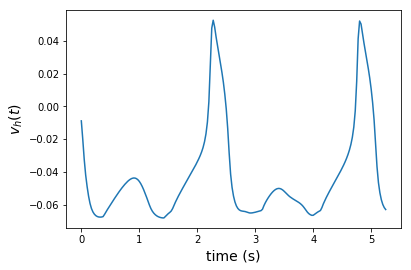

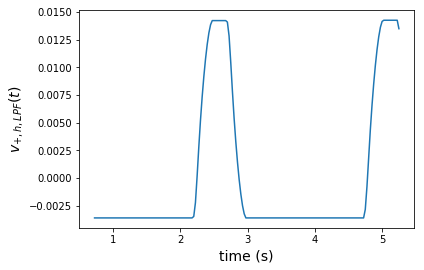

In [95]:
fontsize = 14
t = dt*np.arange(0, T+1)
v_h = X[:,2]
plt.figure()
plt.plot(t, v_h)
plt.xlabel('time (s)', fontsize=fontsize)
plt.ylabel(r'$v_h(t)$', fontsize=fontsize)
plt.show()

v_h_end = v_h[fft_start:]
v_h_rect = np.maximum(v_h_end, 0.00)
v_h_rect_LPF = moving_average(v_h_rect, w)
v_h_rect_LPF = v_h_rect_LPF - np.mean(v_h_rect_LPF)

t_end = dt*np.arange(fft_start+w-1, T+1)
plt.figure()
plt.plot(t_end, v_h_rect_LPF)
plt.xlabel('time (s)', fontsize=fontsize)
plt.ylabel(r'$v_{+,h,LPF}(t)$', fontsize=fontsize)
plt.show()

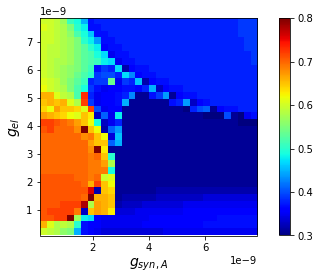

In [96]:
fig = plt.figure(figsize=(8,4))
plt.imshow(max_freqs, origin='lower', vmin=0.3, vmax=0.8, cmap='jet', extent=[g_synA[0], g_synA[-1], g_el[0], g_el[-1]])
ax = plt.gca()
plt.colorbar()
plt.xlabel(r'$g_{syn,A}$', fontsize=fontsize)
plt.ylabel(r'$g_{el}$', fontsize=fontsize)
plt.show()

In [73]:
# parameters for the DSN
g_el = np.array([1.0])*1e-9
g_synA = np.array([2.0])*1e-9
g_synB = 5.0 * (1e-9) # .25 nS  (.25-10 nS) range

num_g_el = g_el.shape[0]
num_g_synA = g_synA.shape[0]

1e-09 2e-09


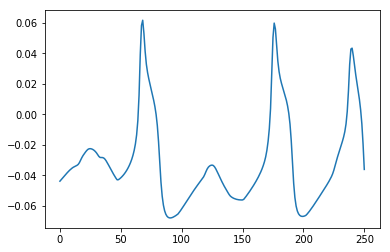

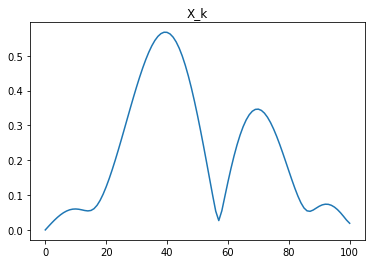

0 0 0.39
took 0.2527730464935303


In [74]:

V_m0 = -65.0e-3*np.ones((5,))
N_0 = 0.25*np.ones((5,))
H_0 = 0.1*np.ones((5,))
x0 = np.concatenate((V_m0, N_0, H_0), axis=0)
x = x0
T = 290
fft_start = 40
dt = 0.025

w = 40

N = T - fft_start + 1 - (w-1) 

Fs = 1.0 / dt

phi_ts = []
min_freq = 0.0
max_freq = 1.0
num_freqs = 101
freqs = np.linspace(min_freq, max_freq, num_freqs)

ns = np.arange(0,N)
for i in range(num_freqs):
    freq_i = freqs[i]
    k = N*freq_i / Fs
    phi_t = np.cos(2*np.pi*k*ns/N) - 1j * np.sin(2*np.pi*k*ns/N)
    phi_ts.append(phi_t)
    
Phi = np.array(phi_ts)

max_freqs = np.zeros((num_g_el, num_g_synA))
for i in range(num_g_el):
    for j in range(num_g_synA):
        print(g_el[i], g_synA[j])
        start_time = time.time()
        xs = [x0]
        for t in range(T):
            dxdt = f(x, g_el[i], g_synA[j], g_synB)
            x = dxdt*dt + x
            xs.append(x)
        X = np.array(xs)
        X_end = X[fft_start:,2]
        plt.figure()
        plt.plot(X_end)
        plt.show()
        X_rect = np.maximum(X_end, 0.0)
        X_rect_LPF = moving_average(X_rect, w)
        X_rect_LPF = X_rect_LPF - np.mean(X_rect_LPF)
        Xk = np.dot(Phi, X_rect_LPF)
        plt.figure()
        plt.plot(np.abs(Xk))
        plt.title('X_k')
        plt.show()
        ind = np.argmax(np.abs(Xk))
        
        max_freqs[i,j] = freqs[ind]
        print(i,j,freqs[ind])
        print('took', time.time() - start_time)